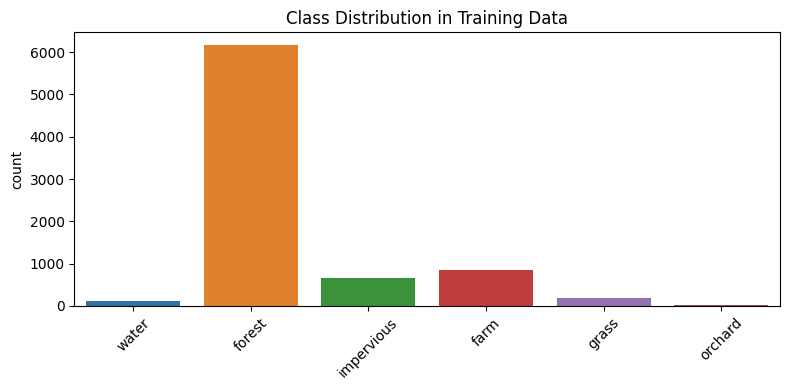

Best C value: {'C': 10}
Average Stratified CV Accuracy: 0.6296250000000001
              precision    recall  f1-score   support

        farm       0.48      0.63      0.54        84
      forest       0.98      0.71      0.82       616
       grass       0.37      0.80      0.51        20
  impervious       0.81      0.87      0.83        67
     orchard       0.03      1.00      0.06         3
       water       0.24      0.50      0.32        10

    accuracy                           0.72       800
   macro avg       0.48      0.75      0.51       800
weighted avg       0.88      0.72      0.78       800



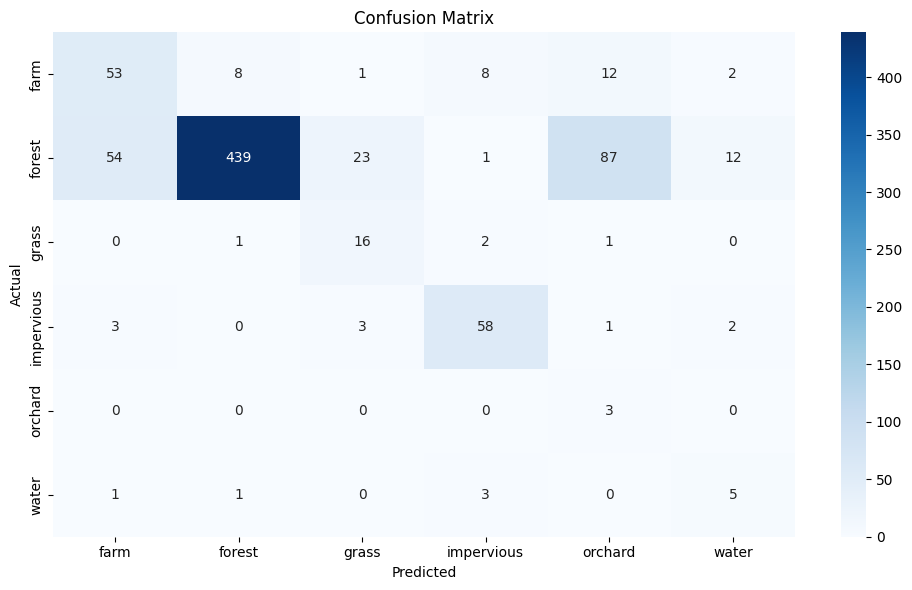


✅ Submission file 'submission.csv' created successfully.


In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer


train_df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")


train_df = train_df.loc[:, ~train_df.columns.str.contains('^Unnamed')]


knn_imputer = KNNImputer(n_neighbors=3)
features_only = train_df.drop(columns=['ID', 'class'])
features_imputed = knn_imputer.fit_transform(features_only)
features_df = pd.DataFrame(features_imputed, columns=features_only.columns)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['class'])


plt.figure(figsize=(8, 4))
sns.countplot(x=label_encoder.inverse_transform(y))
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


features_df['ndvi_mean'] = features_df.mean(axis=1)
features_df['ndvi_std'] = features_df.std(axis=1)
features_df['ndvi_min'] = features_df.min(axis=1)
features_df['ndvi_max'] = features_df.max(axis=1)
features_df['ndvi_trend'] = features_df.apply(lambda row: np.polyfit(range(len(row)), row, 1)[0], axis=1)
features_df['ndvi_peak_index'] = features_df.iloc[:, :-5].idxmax(axis=1).apply(lambda x: int(x.split('_')[0]) if x.split('_')[0].isdigit() else 0)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)


pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)


param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
model = GridSearchCV(LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs', class_weight='balanced'), param_grid, cv=5)
model.fit(X_pca, y)
print("Best C value:", model.best_params_)


skf = StratifiedKFold(n_splits=5)
acc_scores = []

for train_index, val_index in skf.split(X_pca, y):
    X_train_fold, X_val_fold = X_pca[train_index], X_pca[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    model.best_estimator_.fit(X_train_fold, y_train_fold)
    y_val_pred = model.best_estimator_.predict(X_val_fold)
    acc_scores.append(accuracy_score(y_val_fold, y_val_pred))

print("Average Stratified CV Accuracy:", np.mean(acc_scores))


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.10, random_state=42, stratify=y)
model.best_estimator_.fit(X_train, y_train)
y_pred = model.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


test_df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")
test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]
test_ids = test_df['ID']
test_features = test_df.drop(columns=['ID'])
test_imputed = knn_imputer.transform(test_features)
test_df = pd.DataFrame(test_imputed, columns=test_features.columns)


test_df['ndvi_mean'] = test_df.mean(axis=1)
test_df['ndvi_std'] = test_df.std(axis=1)
test_df['ndvi_min'] = test_df.min(axis=1)
test_df['ndvi_max'] = test_df.max(axis=1)
test_df['ndvi_trend'] = test_df.apply(lambda row: np.polyfit(range(len(row)), row, 1)[0], axis=1)
test_df['ndvi_peak_index'] = test_df.iloc[:, :-5].idxmax(axis=1).apply(lambda x: int(x.split('_')[0]) if x.split('_')[0].isdigit() else 0)


test_scaled = scaler.transform(test_df)
test_pca = pca.transform(test_scaled)


test_pred_encoded = model.best_estimator_.predict(test_pca)
test_pred = label_encoder.inverse_transform(test_pred_encoded)

# Save submission
submission = pd.DataFrame({
    'ID': test_ids,
    'class': test_pred
})
submission.to_csv("submission.csv", index=False)
print("\n✅ Submission file 'submission.csv' created successfully.")
